# Calculate global bottom velocity and its std from KDS75

In [1]:
# Load modules
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
from netCDF4 import MFDataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap, shiftgrid # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import xarray
from xarray.ufuncs import square, sqrt
import scipy
from scipy.interpolate import RegularGridInterpolator, griddata

Populating the interactive namespace from numpy and matplotlib


In [2]:
# function to do latitude shifting:
def shifted(input,geolon):
    ny,nx = geolon.shape
    shifted = np.zeros(input.shape)
    for j in range(ny):
        ii = np.max(np.where(geolon[j,:]<-180)) + 1
        shifted[j,(3600-ii):] = input[j,:ii]
        shifted[j,:(3600-ii)] = input[j,ii:]
    return shifted

In [2]:
# Extract the variables
file ='/g/data1/v45/mom01_comparison/KDS75/output162/ocean_grid.nc'

nc = Dataset(file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
lat = nc.variables['yu_ocean'][:]
h = nc.variables['hu'][:]
nc.close() # close the file



In [4]:
#file ='/g/data1/v45/pas561/mom/archive/KDS75/botvel_kds75_258.nc'
#nc = Dataset(file, mode='r') # file handle, open in read only mode
#ubot = nc.variables['ubot'][:]
#vbot = nc.variables['vbot'][:]
#nc.close() # close the file

In [5]:
#option 1 but involves doing things in sections and then patching them up
#f = MFDataset("/g/data1/v45/pas561/mom/archive/KDS75/botvel_kds75_2*nc",exclude=['v'])
#f = MFDataset("/g/data1/v45/pas561/mom/archive/KDS75/SH_botvel_kds75_2*nc")
#f.variable[NAME][10:20,50:60,0,:]
#vbot= f.variables['vbot'][:,:1000,:1000]
#ubot= f.variables['ubot'][:,:1000,:1000]
#print(ubot.shape)
#uvstd=np.ma.std(np.ma.sqrt(vbot**2 + ubot**2),axis=0)
#print(uvstd.shape)

In [3]:
# This is a similar open statement to netCDF4, but notice there is a chunking specification.
file = "/g/data1/v45/pas561/mom/archive/KDS75/botvel_kds75_2*.nc"
f=xarray.open_mfdataset(file,engine='netcdf4',decode_times=False,chunks={'time':10,'xu_ocean':3600,'yu_ocean':2700})
f

<xarray.Dataset>
Dimensions:   (time: 365, xu_ocean: 3600, yu_ocean: 2700)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 -279.4 ...
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 -80.88 ...
  * time      (time) float64 2.446e+04 2.446e+04 2.446e+04 2.446e+04 ...
Data variables:
    ubot      (time, yu_ocean, xu_ocean) float64 nan nan nan nan nan nan nan ...
    vbot      (time, yu_ocean, xu_ocean) float64 nan nan nan nan nan nan nan ...
    hu        (time, yu_ocean, xu_ocean) float64 nan nan nan nan nan nan nan ...

In [7]:
#calculate annual mean vbot and ubot
#write it to a file for cdo regridding
import netCDF4 as nc4
print f.vbot.shape
tavg_vbot=f.vbot.mean('time')
print tmax_ubot.shape

#write vbotto a file 
tavg_vbot.to_dataset(name="tavg_vbot").to_netcdf('/g/data1/v45/pas561/mom/archive/KDS75/tavg_vbot.nc')

#read it in again
file ='/g/data1/v45/pas561/mom/archive/KDS75/tavg_ubot.nc'
nc = Dataset(file, mode='r') # file handle, open in read only mode
uvbot = nc.variables['tavg_ubot'][:]
nc.close() # close the file

#run in terminal window
#ncks -v beta,geolat_t,geolon_t,kmt,geolon_c,geolat_c unmasked_ocean_grid.nc unmasked_vars_for_cdo_regrid.nc

ofile = nc4.Dataset('/g/data1/v45/pas561/mom/archive/KDS75/unmasked_vars_for_cdo_regrid.nc', 'a')

var = ofile.variables['beta']
print var.shape
print uvbot.shape
var[:] = uvbot

ofile.sync()
ofile.close()

#run in terminal window
#cdo remapbil,r3600x2700 -selname,beta unmasked_vars_for_cdo_regrid.nc regrid_beta.nc




(2700, 3600)
(2700, 3600)
(2700, 3600)


In [9]:
#calculate max speed
#write it to a file for cdo regridding
import netCDF4 as nc4
print f.vbot.shape
print f.ubot.shape
#tavg_vbot=f.vbot.mean('time')
tmax=sqrt(square(f.vbot)+square(f.ubot)).max(axis=0)

print tmax.shape

#write vbotto a file 
tmax.to_dataset(name="tmax").to_netcdf('/g/data1/v45/pas561/mom/archive/KDS75/maxspeed_bottom.nc')

#read it in again
file ='/g/data1/v45/pas561/mom/archive/KDS75/maxspeed_bottom.nc'
nc = Dataset(file, mode='r') # file handle, open in read only mode
uvbot = nc.variables['tmax'][:]
nc.close() # close the file

#run in terminal window
#ncks -v beta,geolat_t,geolon_t,kmt,geolon_c,geolat_c unmasked_ocean_grid.nc unmasked_vars_for_cdo_regrid.nc

ofile = nc4.Dataset('/g/data1/v45/pas561/mom/archive/KDS75/unmasked_vars_for_cdo_regrid.nc', 'a')

var = ofile.variables['beta']
print var.shape
print uvbot.shape
var[:] = uvbot

ofile.sync()
ofile.close()

#run in terminal window
#cdo remapbil,r3600x2700 -selname,beta unmasked_vars_for_cdo_regrid.nc regrid_beta.nc


(365, 2700, 3600)
(365, 2700, 3600)
(2700, 3600)
(2700, 3600)
(2700, 3600)


In [19]:
#calculate annual mean vbot and ubot
#write it to a file for cdo regridding
import netCDF4 as nc4
f.ubot.shape
tavg_ubot=f.ubot.mean('time')
print tavg_ubot.shape

#write vbottom a file 
tavg_ubot.to_dataset(name="tavg_ubot").to_netcdf('/g/data1/v45/pas561/mom/archive/KDS75/tavg_ubot.nc')

#read it in again
file ='/g/data1/v45/pas561/mom/archive/KDS75/tavg_ubot.nc'
nc = Dataset(file, mode='r') # file handle, open in read only mode
uvbot = nc.variables['tavg_ubot'][:]
nc.close() # close the file

#run in terminal window
#ncks -v beta,geolat_t,geolon_t,kmt,geolon_c,geolat_c unmasked_ocean_grid.nc unmasked_vars_for_cdo_regrid.nc

ofile = nc4.Dataset('/g/data1/v45/pas561/mom/archive/KDS75/unmasked_vars_for_cdo_regrid.nc', 'a')

var = ofile.variables['beta']
print var.shape
print uvbot.shape
var[:] = uvbot

ofile.sync()
ofile.close()

#run in terminal window
#cdo remapbil,r3600x2700 -selname,beta unmasked_vars_for_cdo_regrid.nc regrid_beta.nc



(2700, 3600)
(2700, 3600)
(2700, 3600)


In [9]:
#print vmax.values

<function matplotlib.pyplot.show>

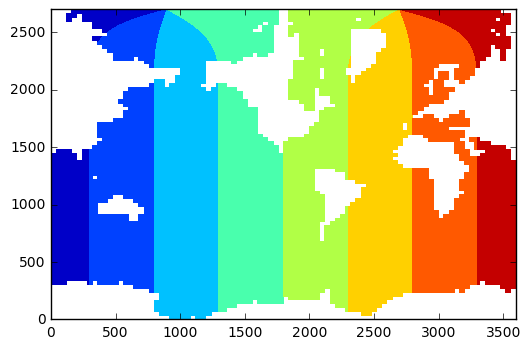

In [10]:
plt.contourf(geolon_t)
plt.show

In [11]:
plt.contourf(xu_ocean,yu_ocean,)

NameError: name 'xu_ocean' is not defined

## make a plot of bottom velocity

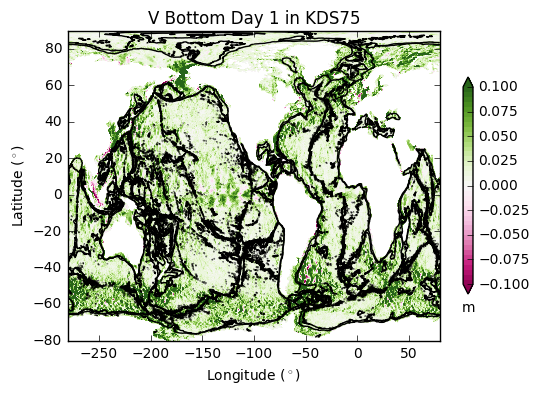

In [12]:
clev = np.arange(-.1,.105,0.005)
klev = np.arange(1000,4000,2000)

plt.contourf(geolon_t,geolat_t,f.vbot[0],cmap=plt.cm.PiYG,levels=clev,extend='both')
#plt.contourf(geolon_t,geolat_t,f.variables['vbot'][0],cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('m')
plt.contour(geolon_t,geolat_t,h,levels=klev,colors='k',linewidth=0.25)

plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Longitude ($^\circ$)')
plt.ylim([-80,90])
plt.xlim([-280,80])
plt.title('V Bottom Day 1 in KDS75')

plt.show()
plt.savefig('V.pdf')

## plot std of bottom vel

In [13]:
#print(f['vbot'].shape)
#vbot= f['vbot']
#ubot= f['ubot']
uvstd=sqrt(square(f.vbot)+square(f.ubot)).std(axis=0)
print(uvstd.shape)

(2700, 3600)


In [14]:
uvstd

<xarray.DataArray (yu_ocean: 2700, xu_ocean: 3600)>
dask.array<sqrt-cf..., shape=(2700, 3600), dtype=float64, chunksize=(2700, 3600)>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 -279.4 ...
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 -80.88 ...

In [15]:
tmp=uvstd.max(dim=None)
print(tmp.values)

/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/dask/array/reductions.py:268: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


0.269099541185


<function matplotlib.pyplot.show>

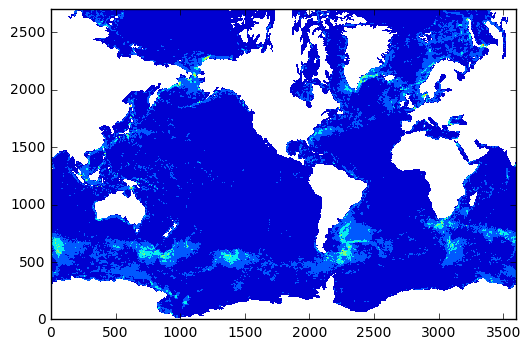

In [16]:
plt.contourf(uvstd)
plt.show

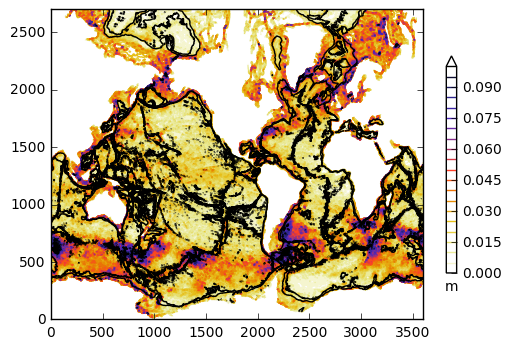

In [17]:
#for some unknown reason it will nolonger plot with geolon_t and geolat_t ... bug in xarray
clev = np.linspace(0,0.1,21)
plt.contour(uvstd,cmap=plt.cm.CMRmap_r,levels=clev,extend='max')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('m')
plt.contour(h,levels=klev,colors='k',linewidth=0.25)

#plt.ylabel('Latitude ($^\circ$)')
#plt.xlabel('Longitude ($^\circ$)')
#plt.ylim([-80,90])
#plt.xlim([-280,80])
#plt.title('Std of Bottom Speed in KDS75')

plt.show()

plt.savefig('std.pdf')

In [31]:
#write uvstd to a file 
uvstd.to_dataset(name="uvbotstd").to_netcdf('/g/data1/v45/pas561/mom/archive/KDS75/uvbotstd.nc')


(1, 2700, 3600)
(2700, 3600)


In [18]:
#tmp=uvstd.max(dim=None)
#print(tmp.values)
#uvstd.data
#uvstd.dims
#uvstd.values[:,1000]

In [19]:
#ubot=None
#vbot=None

In [20]:
#read it in and plot it ...this solves the geolon_t masking problem in plots
file ='/g/data1/v45/pas561/mom/archive/KDS75/uvbotstd.nc'
nc = Dataset(file, mode='r') # file handle, open in read only mode
uvbotstd = nc.variables['uvbotstd'][:]
nc.close() # close the file

In [21]:
uvbotstd.shape

(2700, 3600)

<function matplotlib.pyplot.show>

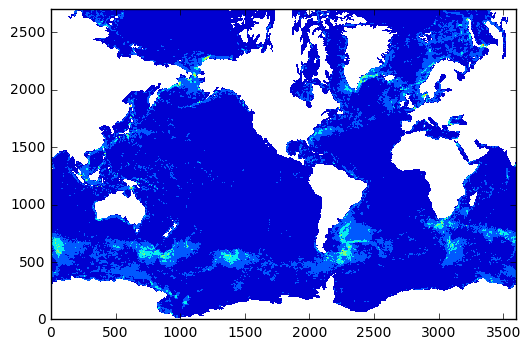

In [22]:
plt.contourf(uvbotstd)
plt.show


In [23]:
#plt.contourf(geolat_t)
#plt.show
#print(geolon_t[:,1])

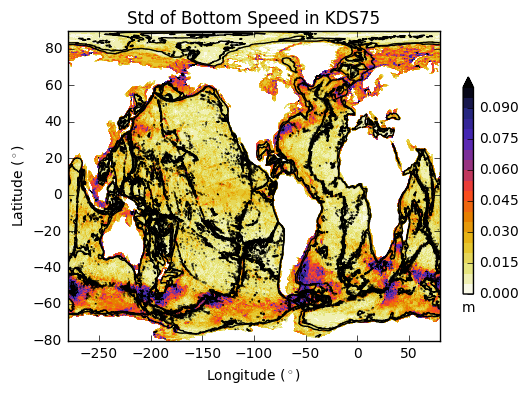

In [24]:
clev = np.linspace(0,0.1,21)
klev = np.arange(1000,4000,2000)

plt.contourf(geolon_t,geolat_t,uvbotstd,cmap=plt.cm.CMRmap_r,levels=clev,extend='max')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('m')
plt.contour(geolon_t,geolat_t,h,levels=klev,colors='k',linewidth=0.25)

plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Longitude ($^\circ$)')
plt.ylim([-80,90])
plt.xlim([-280,80])
plt.title('Std of Bottom Speed in KDS75')

plt.show()

plt.savefig('std.pdf')

## now interpolate to regular grid and write out

In [1]:

#this works by over-writing a variable in an existing netcdf file that has geolon_t and geolat_t
#then use cdo to interpolate to a regular grid.
#the cdo commands need to be done in the terminal window
#vars must be of the same dimension

#import subprocess as sub
import netCDF4 as nc4
ifile = nc4.Dataset('/g/data1/v45/pas561/mom/archive/KDS75/botvel_average.nc')
uvstd = ifile.variables['velocity'][:]

#these don't work in juptyer cause can't access cdo ... maybe module load cdo?
#template_file = '/g/data1/v45/mom01_comparison/KDS75/ocean_month.150.ncra.nc'
#sub.check_call('cdo select,name=mld %s /g/data1/v45/pas561/mom/archive/KDS75/tmp.nc' % template_file, shell=True)


#run in terminal window
#ncks -v beta,geolat_t,geolon_t,kmt,geolon_c,geolat_c unmasked_ocean_grid.nc unmasked_vars_for_cdo_regrid.nc

ofile = nc4.Dataset('/g/data1/v45/pas561/mom/archive/KDS75/unmasked_vars_for_cdo_regrid.nc', 'a')

var = ofile.variables['beta']
print var.shape
print uvstd.shape
var[:] = uvstd

ofile.sync()
ofile.close()

#run in terminal window
#cdo remapbil,r3600x2700 -selname,beta unmasked_vars_for_cdo_regrid.nc regrid_beta.nc
#cdo remapbil,r3600x2700x75 -selname,temp unmasked_vars_for_cdo_regrid.nc regrid_temp.nc



(2700, 3600)
(2700, 3600)


In [5]:
#import subprocess as sub
import netCDF4 as nc4

file1 ='/g/data1/v45/pas561/mom/archive/VertOverturn/mom01_unmasked_ocean_grid.nc'
# Extract the variables
nc = Dataset(file1, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
#beta = nc.variables['beta'][:]
#f_coriolis=nc.variables['f_coriolis'][:]
#potrho = nc.variables['potrho'][:]
#ssh = nc.variables[variable][:]
#mld = nc.variables['mld'][:]
#ty_trans_rho = nc.variables['ty_trans_rho'][0,:,:,:]
nc.close() # close the file
print geolon_t.shape

ofile = nc4.Dataset('/g/data1/v45/pas561/mom/archive/KDS75/unmasked_vars_for_cdo_regrid.nc', 'a')

var = ofile.variables['beta']
print var.shape
print dxt.shape
var[:] = dxt

ofile.sync()
ofile.close()

#run in terminal window
#cdo remapbil,r3600x2700 -selname,beta unmasked_vars_for_cdo_regrid.nc regrid_beta.nc
#cdo remapbil,r3600x2700x75 -selname,temp unmasked_vars_for_cdo_regrid.nc regrid_temp.nc


(2700, 3600)
(2700, 3600)
(2700, 3600)
